In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = 25*sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0   41.2264
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0   10.2415
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0   27.5137
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0   24.796
 2.53849   5.30423   5.84012       0.570453   9.6668    0.0   22.6625
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0   20.3578
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0  -13.6265
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0   25.0373
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0   20.8175
 1.25287   6.88003   3.64868       4.16181    3.00126   0.0   26.2578
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0   36.4211
 1.36551   1.07227   0.570038      2.53062    7.60498   1.0   45.4647
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0   32.6943
 ⋮                              ⋱                       ⋮    
 1.

In [4]:
header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
writedlm("sinus_causal_4.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = 25*sin.(Xtest_1[:, 1]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    result  = []
    )
    if hasproperty(tree, :featid)  
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, result)
        get_all_nodes_in_tree!(tree.right, result)
    end
    return result
end

function get_freq(forest) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree))
    end
    return proportionmap(res)
end

get_freq (generic function with 1 method)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = @btime build_forest_3_opti(false, false, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_11))
print(var(errors_11))

Erreur du modèle préliminaire
0.8481477219882039
Erreur du modèle préliminaire
0.8504304705157537
Erreur du modèle préliminaire
0.8478460578165349
Erreur du modèle préliminaire
0.8482563012141727
  47.226 s (9169363 allocations: 2.53 GiB)
  5.429 s (129474231 allocations: 2.39 GiB)
0.332389489695455956.398351880967059e-5

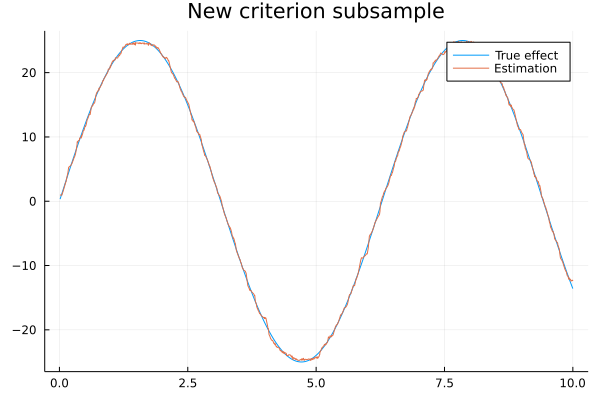

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest_3(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "New criterion subsample", fmt = :png)

In [9]:
cf = build_forest_3_opti(false, false, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)

get_freq(cf)

Erreur du modèle préliminaire
0.8475975452229183


Dict{Any, Float64} with 10 entries:
  5  => 0.0653582
  4  => 0.061622
  6  => 0.066479
  7  => 0.0530662
  2  => 0.0637143
  10 => 0.0616718
  9  => 0.0582594
  8  => 0.0602147
  3  => 0.0561049
  1  => 0.45351

In [ ]:
shaff(cf, 5)

### Bootstrap

In [10]:
errors_12 = zeros(100)

cf = @btime build_forest_3_opti(false, true, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_12))
print(var(errors_12))

Erreur du modèle préliminaire
0.8466883605878313
Erreur du modèle préliminaire
0.8415582098963408
Erreur du modèle préliminaire
0.8515277696729561
Erreur du modèle préliminaire
0.843848339909824
  65.093 s (11203633 allocations: 2.85 GiB)
  6.598 s (138883342 allocations: 2.53 GiB)
0.42062555568761939.068487283581193e-5

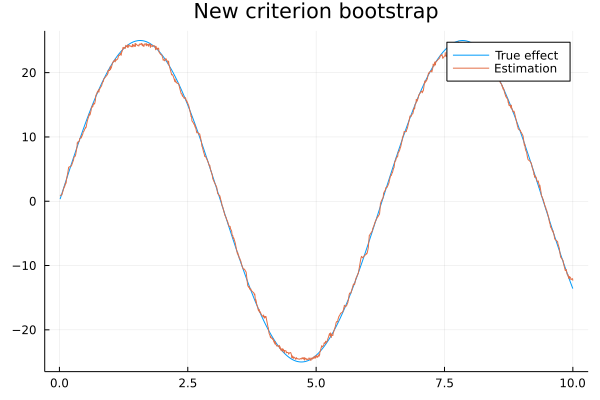

In [11]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest_3(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "New criterion bootstrap", fmt = :png)

In [12]:
cf = build_forest_3_opti(false, true, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)

get_freq(cf)

Erreur du modèle préliminaire
0.8415493867413375


Dict{Any, Float64} with 10 entries:
  5  => 0.0825046
  4  => 0.0799946
  6  => 0.0844364
  7  => 0.0650772
  2  => 0.0788858
  10 => 0.0797293
  9  => 0.0776818
  8  => 0.078811
  3  => 0.0677437
  1  => 0.305136

In [ ]:
shaff(cf, 500)